In [2]:
import torch
import wandb
import os

import numpy as np

from inference.bayesian.models import TorchModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [3]:
config = {
            "dataset": "spain",
            "model_widths": [512, 256, 1],
            "activation": "tanh",
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_samples": 8000,
            "inference": "dropout",
            "dropout_p": 0.566,
            "lr": 0.011,
            "num_iterations": 500,
            "plot": False,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
os.environ["WANDB_NOTEBOOK_NAME"]="main_dropout.ipynb"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# Dropout

In [5]:
torch_model = TorchModel(config.model_widths, config.activation, dropout=True, p=config.dropout_p).to(device)

In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [7]:
predictive, diagnostics = inference(config, torch_model, guide=None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 1:   0%|          | 0/500 [00:01<?, ?it/s, loss=0.00116]c:\Users\mgphy\Anaconda3\envs\uncertainty\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([455])) that is different to the input size (torch.Size([455, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25:   5%|▍         | 24/500 [00:01<00:31, 15.03it/s, loss=0.000512]


Early stopping


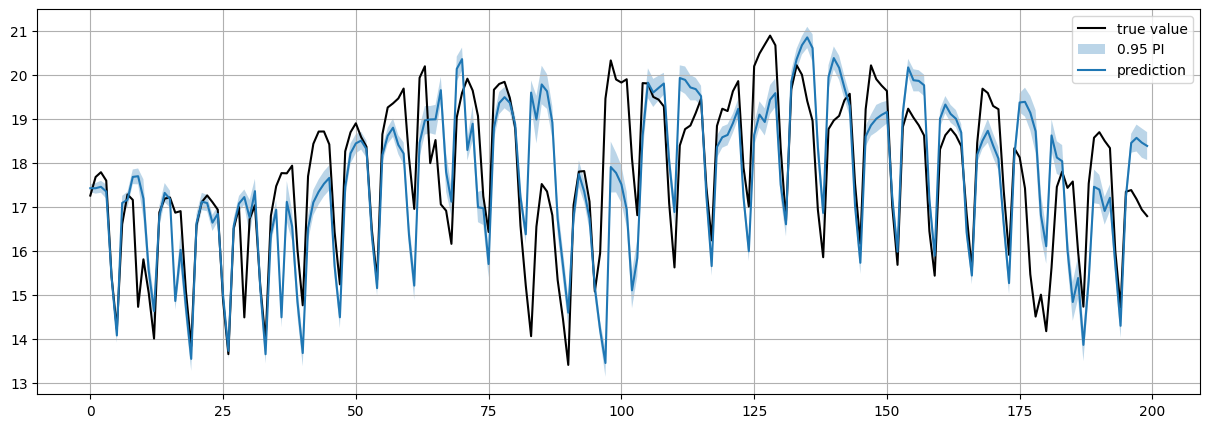

In [9]:
plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), "dropout", 200)

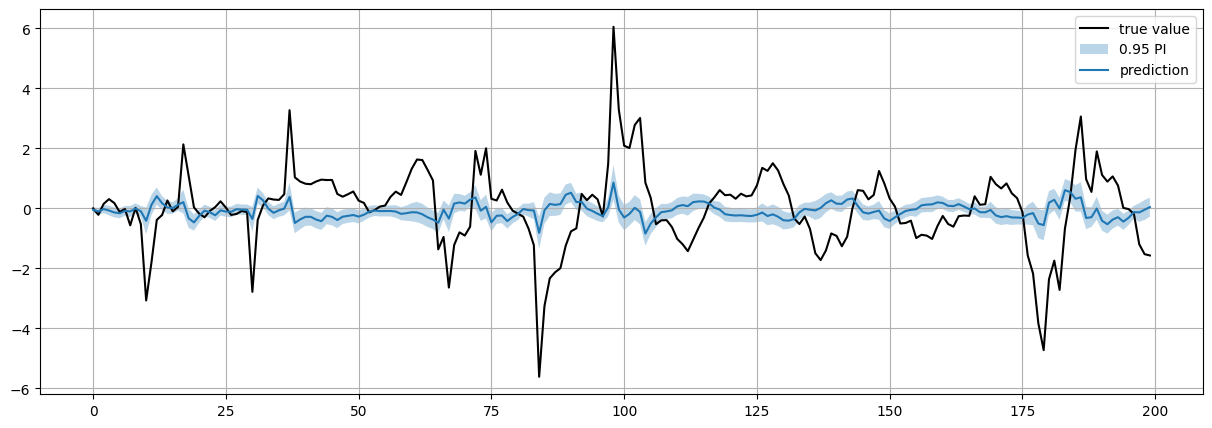

In [10]:
#plot_forecast(predictive, Yte, np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), "svi", 500)
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1].cpu()]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), "svi", 200)

In [9]:
for k, v in diagnostics.items():
    print(k)

train_time
final_loss
inference_time
cal_error
new_cal_error
width
new_width
coverage
avg_length
new_coverage
new_avg_length
mse
new_mse
crps
new_crps


In [11]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  1.265625
calibration error:  2.5800463168699435
Continuous ranked probability score:  0.28682295231827654


In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')

In [22]:
print(diagnostics)

{'train_time': 0.15625, 'final_loss': 1.3000118129089686, 'inference_time': 3.9375, 'cal_error': 0.5262271349273715, 'new_cal_error': 0.010063895131119206, 'width': 3.382735837280528, 'new_width': 3.799286971885833, 'coverage': 0.9608745684695051, 'avg_length': 0.35469378549754815, 'new_coverage': 0.9689298043728424, 'new_avg_length': 0.3983708876697453, 'mse': 0.5294571854941377, 'new_mse': 0.5666421124706603, 'crps': 0.35827556163579194, 'new_crps': 0.35015292232549283}
